In [1]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.ScoringFunctions.Poisson import Poisson
from mdss.MDSS import MDSS

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/mdscan-master/project2_data_26_02_24_autostrat1.csv').drop(columns = ['study_id']).fillna(-999)

target_cols = ['diabetes_status_c_phase2']
data.head()

,age_phase1,site,sex,highest_level_of_education_phase1,partnership_status_c_phase1,ses_site_quintile_c_phase1,occupation_phase1,alcohol_use_status_c_phase1,smoking_status_c_phase1,diabetes_history_phase1,...,change_in_triglycerides,change_in_glucose,change_in_s_creatinine,change_in_insulin,change_in_non_hdl,change_in_egfr,change_in_acr,change_in_mvpa,MAP_phase1,MAP_phase2
0,45.0,3,1,2,1,4,1,3,0,0,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,88.166667,-999.000000
1,46.0,3,1,1,1,2,3,3,1,1,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,111.500000,-999.000000
2,57.0,1,0,0,2,2,2,0,0,0,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,87.500000,-999.000000
3,56.0,1,0,1,2,4,4,0,0,1,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,105.666667,-999.000000
4,56.0,1,1,1,2,2,4,3,2,0,...,-0.01,-0.47,15.88,-999.0,-0.73,-14.779267,-0.301724,2870.0,78.000000,62.666667


In [3]:
data.columns

Index(['age_phase1', 'site', 'sex', 'highest_level_of_education_phase1',
       'partnership_status_c_phase1', 'ses_site_quintile_c_phase1',
       'occupation_phase1', 'alcohol_use_status_c_phase1',
       'smoking_status_c_phase1', 'diabetes_history_phase1', 'mvpa_c_phase1',
       'weight_phase1', 'bmi_c_phase1', 'waist_hip_r_c_phase1',
       'waist_circumference_phase1', 'bp_sys_average_phase1',
       'bp_dia_average_phase1', 'fasting_confirmation_phase1',
       'glucose_result_phase1', 's_creatinine_phase1', 'insulin_result_phase1',
       'hdl_phase1', 'cholesterol_1_phase1', 'friedewald_ldl_c_phase1',
       'triglycerides_phase1', 'hypertension_status_c_phase1',
       'hip_circumference_phase1', 'diabetes_status_c_phase1',
       'non_hdl_c_phase1', 'egfr_c_phase1', 'acr_c_phase1', 'ckd_c_phase1',
       'cvd_status_phase1', 'age_phase2', 'diabetes_status_c_phase2',
       'hypertension_status_phase2', 'smoking_status_c_phase2',
       'diabetes_history_phase2', 'mvpa_c_pha

In [4]:
features = ['age_phase1', 'sex', 'highest_level_of_education_phase1',
       'partnership_status_c_phase1', 'ses_site_quintile_c_phase1',
       'occupation_phase1', 'alcohol_use_status_c_phase1',
       'smoking_status_c_phase1', 'diabetes_history_phase1', 'mvpa_c_phase1',
       'weight_phase1', 'bmi_c_phase1', 'waist_hip_r_c_phase1',
       'waist_circumference_phase1', 'bp_sys_average_phase1','bp_dia_average_phase1',
       'glucose_result_phase1', 's_creatinine_phase1',
       'hdl_phase1', 'cholesterol_1_phase1', 'friedewald_ldl_c_phase1',
       'triglycerides_phase1', 'egfr_c_phase1','acr_c_phase1']
continuous = ['weight_phase1', 'bmi_c_phase1', 'waist_hip_r_c_phase1',
       'waist_circumference_phase1', 'bp_sys_average_phase1','bp_dia_average_phase1',
       'glucose_result_phase1', 's_creatinine_phase1',
       'hdl_phase1', 'cholesterol_1_phase1', 'friedewald_ldl_c_phase1',
       'triglycerides_phase1', 'egfr_c_phase1','acr_c_phase1', 'change_in_weight', 'change_in_bmi',
       'change_in_waist_hip_ratio', 'change_in_waist_circf',
       'change_in_systolic_ave', 'change_in_diastolic_ave',
       'change_in_cholesterol', 'change_in_friedewald', 'change_in_hdl',
       'change_in_triglycerides', 'change_in_glucose',
       'change_in_s_creatinine', 'change_in_insulin', 'change_in_non_hdl',
       'change_in_egfr', 'change_in_acr', 'change_in_mvpa']

In [5]:
site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id)].fillna(-999)
# dff = dff2[(dff2['site'] == site_id)& (dff2['age_phase1'] <= 60) & (dff2['age_phase1'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 76)
Size after removing records with missing targets:  (813, 76)


In [6]:
dff.diabetes_status_c_phase2.value_counts()

0.0    685
1.0    128
Name: diabetes_status_c_phase2, dtype: int64

In [7]:
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

<Axes: ylabel='Density'>

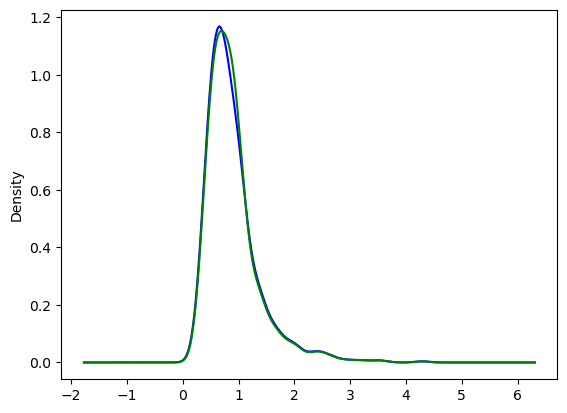

In [8]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1[continuous])
train_t = imputer.transform(dff1[continuous])
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1[continuous].columns)

fig = plt.figure()
ax = fig.add_subplot(111)
dff1['triglycerides_phase1'].plot(kind='kde', ax=ax, color='blue')
treated['triglycerides_phase1'].plot(kind='kde', ax=ax, color='green')

In [9]:
dff = dff[features + target_cols].copy()
dff.reset_index(inplace=True, drop=True)
dff[continuous] = treated[continuous]
dff['age_phase1'] = dff.age_phase1.astype(int)

In [10]:
numeric_columns = [col for col in dff.columns \
                     if (is_numeric_dtype(dff[col])) \
                     & (col not in target_cols) \
                     & (dff[col].nunique() > 10)]

In [20]:
# Specify the columns of interest
# columns_of_interest = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current'] 


# defining the outcome variable
dff['MorbidityCount'] = (dff[target_cols] == 1)
# treated['MorbidityCount'] = (dff[target_cols] == 1).sum(axis = 1)

# defining the expectations as mean of the target
# treated['expectation'] = treated[target_col].mean()
# treated['expectationPoisson'] = treated['normalizedOutcome'].mean()
# treated['expectationPoisson'] = treated['MorbidityCount'].mean()
dff['expectation'] = dff['MorbidityCount'].mean()

In [21]:
dff['expectation']

0      0.157442
1      0.157442
2      0.157442
3      0.157442
4      0.157442
         ...   
808    0.157442
809    0.157442
810    0.157442
811    0.157442
812    0.157442
Name: expectation, Length: 813, dtype: float64

In [28]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space1 = [col for col in dff.columns \
                if col not in \
                ['age_phase2','index','site',
       'diabetes_status_c_phase2', 'hypertension_status_phase2',
       'smoking_status_c_phase2', 'diabetes_history_phase2', 'mvpa_c_phase2',
       'weight_phase2', 'bmi_c_phase2', 'waist_circumference_phase2', 'change_in_waist_hip_ratio', 'change_in_waist_circf', 'change_in_systolic_ave', 'change_in_triglycerides', 'change_in_glucose', 'change_in_mvpa',
       'waist_hip_r_c_phase2', 'bp_sys_average_phase2','hypertension_status_c_phase1','diabetes_status_c_phase1','non_hdl_c_phase1',
       'bp_dia_average_phase2', 'fasting_confirmed_phase2','hip_circumference_phase1', 'hip_circumference_phase2',
       'glucose_result_phase2', 's_creatinine_phase2', 'insulin_result_phase2', 'cholesterol_1_phase2', 'friedewald_ldl_c_phase2',
       'triglycerides_phase2', 'non_hdl_c_phase2', 'egfr_c_phase2','acr_c_phase2', 'change_in_weight', 'change_in_bmi','change_in_diastolic_ave',
       'change_in_cholesterol', 'change_in_friedewald', 'change_in_hdl', 'bp_sys_average_phase1','ckd_c_phase1', 'bp_dia_average_phase1', 'acr_c_phase1',
 'cvd_status_phase1','insulin_result_phase1','hdl_phase2','fasting_confirmation_phase1','weight_phase1','partnership_status_c_phase1',
       'change_in_s_creatinine', 'change_in_insulin', 'change_in_non_hdl','s_creatinine_phase1', 'glucose_result_phase1', 
       'change_in_egfr', 'change_in_acr', 'MAP_phase1',#'diabetes_history_phase1', 'mvpa_c_phase1', 
       'MAP_phase2', 'MorbidityCount', 'expectation','expectationPoisson']]

In [29]:
(search_space1)

['age_phase1',
 'sex',
 'highest_level_of_education_phase1',
 'ses_site_quintile_c_phase1',
 'occupation_phase1',
 'alcohol_use_status_c_phase1',
 'smoking_status_c_phase1',
 'diabetes_history_phase1',
 'mvpa_c_phase1',
 'bmi_c_phase1',
 'waist_hip_r_c_phase1',
 'waist_circumference_phase1',
 'hdl_phase1',
 'cholesterol_1_phase1',
 'friedewald_ldl_c_phase1',
 'triglycerides_phase1',
 'egfr_c_phase1']

In [30]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser
            

In [31]:
contiguous = {}
dff_2 = dff.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space1:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [33]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        # desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'
        desc += key + '{' + ' OR '.join(value) + '} AND' + ' '

    return desc[:-5].replace('_',' ').replace('{', '[').replace('}', ']')

def count_conditions(subset):
    # Split the string by 'AND' and 'OR'
    conditions = subset.replace("AND", "OR").split("OR")
    
    # Count the number of conditions
    condition_count = len(conditions)
    
    return condition_count

In [34]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
# penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
penalty_values = [1.0, 1.5, 2, 2.5, 3.0,3.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space1], dff_2[target_cols], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    size = len(temp_df)
    observed_income = np.round(temp_df[target_cols].mean(), 3)
    positive_class_count = temp_df[target_cols].sum()

    group_obs = temp_df[target_cols].mean()
    group_prob = temp_df['expectation'].mean()
    odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))
    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_results.append(size)
    odds_results.append(np.round(odds_mul, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)


# # Display the results for each penalty value
# for i, penalty in enumerate(penalty_values):
#     print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, Odds = {odds_results[i]}, Score = {score_results[i]}")

Penalty = 1.0: Subset = age phase1[46.0 - 70.0] AND ses site quintile c phase1[4 OR 5] AND bmi c phase1[28.39 - 54.29] AND triglycerides phase1[0.98 - 4.29], 
LiteralsNumber = 5, 
Size = 53, Odds = diabetes_status_c_phase2    5.557
dtype: float64, Score = 12.642
Penalty = 1.5: Subset = mvpa c phase1[120.0 - 2400.0] AND age phase1[42.0 - 70.0] AND waist hip r c phase1[0.87 - 1.16] AND hdl phase1[1.16 - 1.28] AND occupation phase1[1 OR 4] AND triglycerides phase1[0.98 - 4.29], 
LiteralsNumber = 7, 
Size = 14, Odds = diabetes_status_c_phase2    inf
dtype: float64, Score = 15.382
Penalty = 2: Subset = triglycerides phase1[1.11 - 4.29] AND waist hip r c phase1[1.0 - 1.16] AND waist circumference phase1[990.0 - 1420.0], 
LiteralsNumber = 3, 
Size = 29, Odds = diabetes_status_c_phase2    10.168
dtype: float64, Score = 12.157
Penalty = 2.5: Subset = waist circumference phase1[990.0 - 1420.0] AND waist hip r c phase1[1.0 - 1.16] AND triglycerides phase1[1.11 - 4.29], 
LiteralsNumber = 3, 
Size 